<a href="https://colab.research.google.com/github/Airaat/ml-study/blob/main/rnn_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Covid19 Daily 2020

In [127]:
!pip install -U datasets

## Importing essential modules

In [128]:
import random

from datasets import load_dataset
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## Loading dataset. Normalizing data to Pandas Dataframe

In [129]:
data = load_dataset("WorkWithData/Country_Covid19_Daily_2020", split="train").to_pandas()
russian_data = data[data["Country"] == "Russia"].reset_index(drop=True)

## Show dataset content

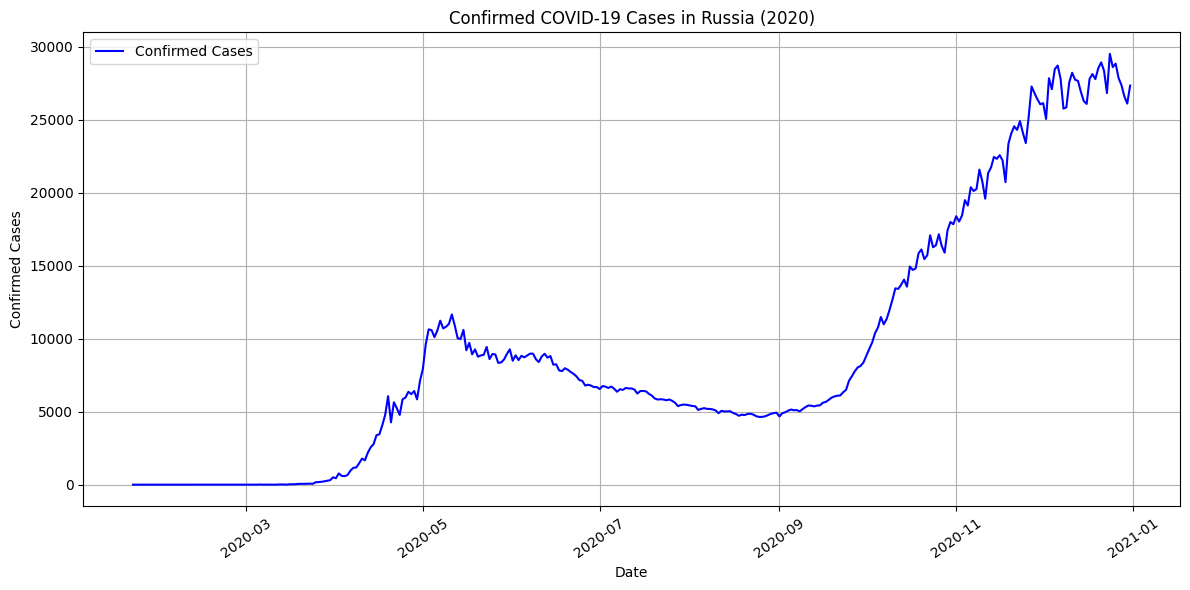

,Country,Date,Covid cases,Covid deaths,Average number of cases over the last 7 days,Average number of covid deaths over the last 7 days
0,Russia,2020-01-22,0,0,0,0
1,Russia,2020-01-23,0,0,0,0
2,Russia,2020-01-24,0,0,0,0
3,Russia,2020-01-25,0,0,0,0
4,Russia,2020-01-26,0,0,0,0
...,...,...,...,...,...,...
340,Russia,2020-12-27,27849,541,28406,548
341,Russia,2020-12-28,27363,479,28184,548
342,Russia,2020-12-29,26588,548,27934,547
343,Russia,2020-12-30,26095,585,27831,554


In [130]:
russian_data["Date"] = pd.to_datetime(russian_data["Date"])

plt.figure(figsize=(12, 6))
plt.plot(russian_data["Date"], russian_data["Covid cases"], label="Confirmed Cases", color="blue")
plt.title("Confirmed COVID-19 Cases in Russia (2020)")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.xticks(rotation=35)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

russian_data

## Preprocess data. Normalization

In [131]:
def create_sequences(data, seq_length):
  X, y = [], []
  for i in range(len(data) - seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
  return np.array(X), np.array(y)

confirmed_cases = russian_data["Covid cases"]
scaler = MinMaxScaler(feature_range=(0,1))
confirmed_normalized = scaler.fit_transform(confirmed_cases.values.reshape(-1, 1))

seq_length = 10
X, y = create_sequences(confirmed_normalized, seq_length)
train_size = int(len(X) * 0.8)

X_train = torch.tensor(X[:train_size], dtype=torch.float32)
X_test = torch.tensor(X[train_size:], dtype=torch.float32)
y_train = torch.tensor(y[:train_size], dtype=torch.float32)
y_test = torch.tensor(y[train_size:], dtype=torch.float32)

In [132]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Параметры модели
input_size = 1  # Один признак (Confirmed)
hidden_size = 50  # Количество нейронов в скрытом слое
output_size = 1  # Прогнозируем одно значение
num_layers = 1  # Количество слоев RNN

model = RNNModel(input_size, hidden_size, output_size, num_layers)

## Training loop

In [133]:
num_epochs = 100
lr = 0.01

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()
  outputs = model(X_train)
  loss = criterion(outputs, y_train)
  loss.backward()
  optimizer.step()

  if (epoch + 1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.4f}')

Epoch [10/100], loss: 0.0058
Epoch [20/100], loss: 0.0008
Epoch [30/100], loss: 0.0003
Epoch [40/100], loss: 0.0002
Epoch [50/100], loss: 0.0001
Epoch [60/100], loss: 0.0001
Epoch [70/100], loss: 0.0001
Epoch [80/100], loss: 0.0001
Epoch [90/100], loss: 0.0001
Epoch [100/100], loss: 0.0001


## Validation of model prediction

test loss: 0.0008


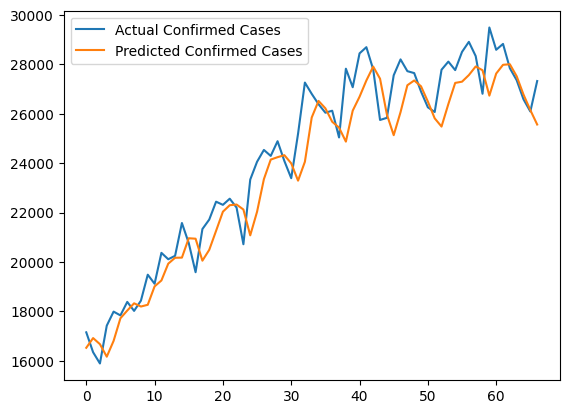

In [134]:
model.eval()
with torch.no_grad():
  test_outputs = model(X_test)
  test_loss = criterion(test_outputs, y_test)
  print(f'test loss: {test_loss.item():.4f}')

predicted = scaler.inverse_transform(test_outputs.numpy())
actual = scaler.inverse_transform(y_test.numpy())

plt.plot(actual, label="Actual Confirmed Cases")
plt.plot(predicted, label="Predicted Confirmed Cases")
plt.legend()
plt.show()